In [160]:

import matplotlib.pyplot as plt
import math
import numpy as np 
import pandas as pd 
import io 
import requests
import datetime as dt


In [161]:
def Calculate_Saturation_vapour_pressure(t):
    return 610.78*math.exp((t/(t+238.3))*17.2694)
def Calculate_vapour_pressure_From_Humdity(RH,t):
    return (RH)*610.78*math.exp((t/(t+238.3))*17.2694)
def ConvertAirFrom_PPM_To_mgDivm3(x):
    return x*(1/0.554)


In [162]:
M_water=18 #kg (kmol)^-1
h_Air=3.8 #m
R=8314 #J*(kmol)^-1*K^-1
h_Gh=4.2 #m
Eta_Global_Air=0.1 #no unit
Eta_Global_PAR=0.5 #no unit
Tau_Cov_PAR=0.534311577 #no unit
Eta_Global_NIR=0.5 #no unit
Tau_Cov_NIR=0.534311577 #no unit
c_evap1=4.3 #W*m^-2
c_evap2=0.54 #W*m^-2
s_r_s=-1 #m/W^2
R_Can_SP= 5 #W*m^-2
night_c_evap3= 1.1*(10**(-11)) #ppm^-2
day_c_evap3= 6.1*(10**(-7)) #ppm^-2
night_c_evap4= 5.2*(10**(-6)) #Pa^-2
day_c_evap4= 4.3*(10**(-6)) #Pa^-2
eta_mg_ppm= 0.554 #ppm*mg^-1*m^3
r_s_min= 82 #s/m
rho_Air= 1.2 #kg/m^3
c_p_Air= 1000 #J/(K*kg)
LAI=3 #m^2 {leaf} m^-2
deltaH=2.45*(10**6) #J/(kg{Water})
gamma=65.8 #Pa*K^-1
r_b= 275 #s/m
U_Pad= 1 #no unit
phi_Pad=35.6#m^3/s ######################################3
A_Flr=14000 #m^2
eta_Pad=0
x_Pad=0
x_Out=0
U_Fog=1
phi_Fog=0
eta_HeatVap= 4.43*(10**(-8)) #Kg vapour/ J
U_Blow=1
P_Blow=500 #W
U_ThScr=0.75
K_ThScr=0.05*(10**(-3)) #m*K^(-2/3)*s^(-1)
Delta_T_AirTop=1
g=9.81 #(m/s^2)
RO_Mean=1.2 #kg*m^(-3) 
Delta_RO=0.0004837 #? #kg*m^(-3)
Zeta_InsScr=1
C_leakage=1*(10**(-4))
C_d=0.75
U_Roof=0.05
U_Side=0.05
A_Roof=1400 #m^2
A_Side=1400 #m^2
h_Roof=0.68 #m
h_SideRoof=1.9 #m
Delta_T_AirOut=-5 #k
T_mean=298 #K
C_w=0.09
Eta_RoofThr=0.9
Eta_SideThr=0.9
U_MechCool=1
COP_MechCool=0 #no unit
P_MechCool=0 #no unit
A_Cov=18000 #m^2
c_HECin=1.86 #W*m^-2*K^-1
U_VentForced=1
Phi_VentForced=0

Biến khởi tạo trong vòng lặp:


In [163]:
def def_cap_VP_Air(M_water, h_Air, R, T_Air):
    return ((M_water*h_Air)/(R*(T_Air+273.15)))
def def_cap_VP_Top(M_water, h_Gh, R, T_Top):
    return ((M_water*h_Gh)/(R*(T_Top+273.15)))

def def_R_Can(Eta_Global_Air,I_Global,Eta_Global_PAR,Tau_Cov_PAR,Eta_Global_NIR,Tau_Cov_NIR):
    return (1-Eta_Global_Air)*I_Global*(Eta_Global_PAR*Tau_Cov_PAR+Eta_Global_NIR*Tau_Cov_NIR)
def def_rf_R_can(R_Can, c_evap1, c_evap2):
    return (R_Can + c_evap1)/(R_Can + c_evap2)

def def_S_r_S(s_r_s, R_Can, R_Can_SP):
    return 1/(1+math.exp(s_r_s*(R_Can-R_Can_SP)))

def def_c_evap3(night_c_evap3, S_r_S,day_c_evap3):
    return night_c_evap3*(1-S_r_S)+day_c_evap3*S_r_S


def def_c_evap4(night_c_evap4, S_r_S,day_c_evap4):
    return night_c_evap4*(1-S_r_S)+day_c_evap4*S_r_S

def def_rf_CO2_Air_ppm(c_evap3, eta_mg_ppm, CO2_Air):
    return ( 1+ c_evap3*((eta_mg_ppm*CO2_Air-200)**2) )

def def_rf_VP_Can_VP_Air(c_evap4, VP_Can, VP_Air):
    return (1+c_evap4*(VP_Can-VP_Air)**(2))

def def_r_s(r_s_min, rf_R_Can, rf_CO2_Air_ppm, rf_VP_Can_VP_Air):
    return (r_s_min*rf_R_Can*rf_CO2_Air_ppm*rf_VP_Can_VP_Air)

def def_VEC_CanAir(rho_Air, c_p_Air, LAI, deltaH, gamma, r_b, r_s):
    return (2*rho_Air*c_p_Air*LAI)/(deltaH*gamma*(r_b+r_s))

def def_MV_CanAir(VEC_CanAir, VP_Can, VP_Air):
    return (VEC_CanAir*(VP_Can-VP_Air))


def def_f_Pad(U_Pad,phi_Pad,A_Flr):
    return U_Pad*phi_Pad/A_Flr
def def_MV_PadAir(rho_Air, f_Pad, eta_Pad, x_Pad, x_Out):
    return (rho_Air*f_Pad*(eta_Pad*(x_Pad-x_Out)+x_Out))


def def_MV_AirOut_Pad(f_Pad, M_water, VP_Air, R, T_Air):
    return (f_Pad*(M_water/R)*(VP_Air/(T_Air+273.15)))

def def_MV_FogAir(U_Fog, pi_Fog, A_Flr):
    return (U_Fog*phi_Fog/A_Flr)

def def_MV_BlowAir(eta_HeatVap, U_Blow, P_Blow, A_Flr):
    return ((eta_HeatVap*U_Blow*P_Blow)/A_Flr)

def def_HEC_AirThScr(U_ThScr, T_Air, T_ThScr):
    return (1.7*U_ThScr*abs(T_Air-T_ThScr)**(0.33))
def def_MV_AirThScr(HEC_AirThScr, VP_Air, VP_ThScr):
    if (VP_Air < VP_ThScr):
        return 0
    else:
        return (6.4*((10**(-9))*HEC_AirThScr*(VP_Air-VP_ThScr)))

def def_HEC_AirMech(U_MechCool, COP_MechCool, P_MechCool, A_Flr, T_Air, T_MechCool, deltaH, VP_Air, VP_MechCool):
    return (U_MechCool*COP_MechCool*P_MechCool/A_Flr)/(T_Air-T_MechCool + 6.4*(10**(-9))*deltaH*(VP_Air-VP_MechCool))
def def_MV_AirMech(HEC_AirMech, VP_Air, VP_MechCool):
    if (VP_Air < VP_MechCool):
        return 0
    else:
        return (6.4*(10**(-9))*HEC_AirMech*(VP_Air-VP_MechCool))

def def_HEC_TopCov_in(C_HECin, T_Top, T_Cov_in, A_Cov, A_Flr):
    return (c_HECin*((T_Top-T_Cov_in)**(0.33))*A_Cov/A_Flr)
def def_MV_TopCov_in(HEC_TopCov_in, VP_Top, VP_Cov_in):
    if (VP_Top <VP_Cov_in):
        return 0
    else:
        return (6.4*(10**(-9))*HEC_TopCov_in*(VP_Top-VP_Cov_in))
    
def def_f_ThScr(U_ThScr,K_ThScr,Delta_T_AirTop,g,RO_Mean,Delta_RO):
    return U_ThScr*K_ThScr*((Delta_T_AirTop)**(2/3))+(1-U_ThScr)*(((g*(1-U_ThScr)/(2*RO_Mean))*Delta_RO)**(1/2))

def def_MV_AirTop(M_water, f_ThScr, VP_Air, VP_Top, R, T_Air, T_Top):
    return (M_water/R)*f_ThScr*((VP_Air/(T_Air+273.15))-(VP_Top/(T_Top+273.15)))

def def_f_VentSide(Eta_InsScr,ff_VentSide,f_leakage,U_ThScr,f_VentRoofSide,Eta_Side,Eta_SideThr):
    if (Eta_Side>=Eta_SideThr):
        return Eta_InsScr*ff_VentSide+0.5*f_leakage
    else:
        return Eta_InsScr*(U_ThScr*ff_VentSide+(1-U_ThScr)*f_VentRoofSide*Eta_Side)+0.5*f_leakage



def def_Eta_InsScr(Zeta_InsScr):
    return Zeta_InsScr*(2-Zeta_InsScr)

def def_f_leakage(v_Wind,C_leakage):
    if (v_Wind<0.25):
        return 0.25*C_leakage
    else:
        return v_Wind*C_leakage
def def_f_VentRoofSide(C_d,A_Flr,U_Roof,A_Roof,U_Side,A_Side,g,h_SideRoof,Delta_T_AirOut,T_mean,C_w,v_Wind):
    component1=C_d/A_Flr
    component2=((U_Roof**2)*(U_Side**2)*(A_Roof**2)*(A_Side**2))/((U_Roof**2)*(A_Roof**2)+(U_Side**2)*(A_Side**2))
    component3=(2*g*h_SideRoof*Delta_T_AirOut)/T_mean
    component4=(((U_Roof*A_Roof+U_Side*A_Side)/2)**2)*C_w*(v_Wind**2)
    return component1*((component2*component3+component4)**(1/2))

def def_f_VentForced(Eta_InsScr,U_VentForced,Phi_VentForced,A_Flr):
    return Eta_InsScr*U_VentForced*Phi_VentForced/A_Flr

def def_MV_AirOut(M_water, f_ventSide, f_ventForced, VP_Air, VP_Out, R, T_Air, T_Out):
    return (M_water/R)*(f_ventSide+f_ventForced)*((VP_Air/(T_Air+273.15))-(VP_Out/(T_Out+273.15)))

def def_ff_VentRoof(C_d,U_Roof,A_Roof,A_Flr,g,h_Roof,Delta_T_AirOut,T_mean,C_w,v_Wind):
    component1=C_d*U_Roof*A_Roof/(2*A_Flr)
    component2=(g*h_Roof*Delta_T_AirOut/(2*T_mean))+C_w*(v_Wind**2)
    return component1*(component2**(1/2))

def def_f_VentRoof(Eta_InsScr,ff_VentRoof,f_leakage,U_ThScr,f_VentRoofSide,Eta_Roof,Eta_RoofThr):
    if (Eta_Roof>=Eta_RoofThr):
        return Eta_InsScr*ff_VentRoof+0.5*f_leakage
    else:
        return Eta_InsScr*(U_ThScr*ff_VentRoof+(1-U_ThScr)*f_VentRoofSide*Eta_Roof)+0.5*f_leakage
def def_MV_TopOut(M_water, f_ventRoof, VP_Top, VP_Out, R, T_Top, T_Out):
    return (M_water/R)*f_ventRoof*((VP_Top/(T_Top+273.15))-(VP_Out/(T_Out+273.15)))

In [164]:
def dx(cap_VP_Air,cap_VP_Top, MV_CanAir, MV_PadAir, MV_FogAir, MV_AirThScr, MV_AirOut, MV_AirOut_Pad, MV_AirTech, MV_AirTop, MV_TopCov_in, MV_TopOut):
    cap_VP_Air = def_cap_VP_Air(M_water, h_Air, R, T_Air)
    #print("cap_VPAir = ", cap_VP_Air)
    #print()

    cap_VP_Top = def_cap_VP_Top(M_water, h_Gh, R, T_Top)
    #print("cap_VP_Top = ", cap_VP_Top)
    #print()
    
    R_Can=def_R_Can(Eta_Global_Air,I_Global,Eta_Global_PAR,Tau_Cov_PAR,Eta_Global_NIR,Tau_Cov_NIR)
    #print("R_Can=",R_Can)
    rf_R_Can =  def_rf_R_can(R_Can, c_evap1, c_evap2)
    #print("rf_R_Can=",rf_R_Can)
    S_r_S = def_S_r_S(s_r_s, R_Can, R_Can_SP)
    #print("S_r_S=",S_r_S)
    c_evap3 = def_c_evap3(night_c_evap3,S_r_S,day_c_evap3)
    #print("c_evap3=",c_evap3)
    c_evap4 = def_c_evap4(night_c_evap4,S_r_S,day_c_evap4)
    #print("c_evap4=",c_evap4)
    rf_CO2_Air_ppm = def_rf_CO2_Air_ppm(c_evap3, eta_mg_ppm, CO2_Air)
    #print("rf_CO2_Air_ppm=",rf_CO2_Air_ppm)
    rf_VP_Can_VP_Air = def_rf_VP_Can_VP_Air(c_evap4, VP_Can, VP_Air)
    #print("rf_VP_VP_Air=",rf_VP_Can_VP_Air)
    r_s = def_r_s(r_s_min, rf_R_Can, rf_CO2_Air_ppm, rf_VP_Can_VP_Air)
    #print("r_s=",r_s)
    VEC_CanAir = def_VEC_CanAir(rho_Air, c_p_Air, LAI, deltaH, gamma, r_b, r_s)
    #print("VEC_CanAir=",VEC_CanAir)
    MV_CanAir = def_MV_CanAir(VEC_CanAir, VP_Can, VP_Air)
    #print("Mv_CanAir = ", MV_CanAir)
    #print()
    
    f_Pad=def_f_Pad(U_Pad,phi_Pad,A_Flr)
    #print("f_Pad=",f_Pad)
    MV_PadAir = def_MV_PadAir(rho_Air, f_Pad, eta_Pad, x_Pad, x_Out)
    #print("MV_PadAir = ",MV_PadAir)
    #print()
    
    MV_AirOut_Pad = def_MV_AirOut_Pad(f_Pad, M_water, VP_Air, R, T_Air)
    #print("MV_AirOut_Pad = ", MV_AirOut_Pad)
    #print()

    MV_FogAir = def_MV_FogAir(U_Fog, phi_Fog, A_Flr)
    #print("MV_FogAir = ", MV_FogAir)
    #print()
    
    MV_BlowAir = def_MV_BlowAir(eta_HeatVap, U_Blow, P_Blow, A_Flr)
    #print("MV_BlowAir = ", MV_BlowAir)
    #print()
    
    HEC_AirThScr = def_HEC_AirThScr(U_ThScr, T_Air,T_ThScr)
    #print("HEC_AirThScr=",HEC_AirThScr)
    MV_AirThScr = def_MV_AirThScr(HEC_AirThScr, VP_Air, VP_ThScr)
    #print("MV_AirThScr = ", MV_AirThScr)
    #print()
    
    HEC_AirMech = def_HEC_AirMech(U_MechCool, COP_MechCool, P_MechCool, A_Flr, T_Air, T_MechCool, deltaH, VP_Air, VP_MechCool)
    #print("HEC_AirMech=",HEC_AirMech)
    MV_AirMech = def_MV_AirMech(HEC_AirMech, VP_Air, VP_MechCool)
    #print("MV_AirMech = ", MV_AirMech)
    #print()
    
    HEC_TopCov_in = def_HEC_TopCov_in(c_HECin, T_Top, T_Cov_in, A_Cov, A_Flr)
    MV_TopCov_in = def_MV_TopCov_in(HEC_TopCov_in, VP_Top, VP_Cov_in)
    #print("MV_TopCov_in = ", MV_TopCov_in)
    #print()
    
    f_ThScr=def_f_ThScr(U_ThScr,K_ThScr,Delta_T_AirTop,g,RO_Mean,Delta_RO)
    #print("f_ThScr=",f_ThScr)
    MV_AirTop = def_MV_AirTop(M_water, f_ThScr, VP_Air, VP_Top, R, T_Air, T_Top)
    #print("MV_AirTop = ", MV_AirTop)
    #print()

    Eta_InsScr=def_Eta_InsScr(Zeta_InsScr)
    #print("Eta_InsScr=",Eta_InsScr)
    f_leakage=def_f_leakage(v_Wind,C_leakage)
    #print("f_leakage=",Eta_InsScr)
    f_VentRoofSide=def_f_VentRoofSide(C_d,A_Flr,U_Roof,A_Roof,U_Side,A_Side,g,h_SideRoof,Delta_T_AirOut,T_mean,C_w,v_Wind)
    #print("f_VentRoofSide=",f_VentRoofSide)
    ff_VentSide=def_f_VentRoofSide(C_d,A_Flr,U_Roof,0,U_Side,A_Side,g,h_SideRoof,Delta_T_AirOut,T_mean,C_w,v_Wind) # A_Roof=0
    #print("ff_VentSide=",ff_VentSide)
    f_ventSide = def_f_VentSide(Eta_InsScr,ff_VentSide,f_leakage,U_ThScr,f_VentRoofSide,Eta_Side,Eta_SideThr)
    #print("f_ventSide=",f_ventSide)
    f_ventForced = def_f_VentForced(Eta_InsScr,U_VentForced,Phi_VentForced,A_Flr)
    #print("f_ventForced=",f_ventForced)
    MV_AirOut = def_MV_AirOut(M_water, f_ventSide, f_ventForced, VP_Air, VP_Out, R, T_Air, T_Out)
    #print("MV_AirOut = ", MV_AirOut)
    #print()
    
    ff_VentRoof=def_ff_VentRoof(C_d,U_Roof,A_Roof,A_Flr,g,h_Roof,Delta_T_AirOut,T_mean,C_w,v_Wind)
    #print("ff_VentRoof=",ff_VentRoof)
    f_ventRoof = def_f_VentRoof(Eta_InsScr,ff_VentRoof,f_leakage,U_ThScr,f_VentRoofSide,Eta_Roof,Eta_RoofThr)
    #print("f_ventRoof=",f_ventRoof)
    MV_TopOut = def_MV_TopOut(M_water, f_ventRoof, VP_Top, VP_Out, R, T_Top, T_Out)
    #print("MV_TopOut = ", MV_TopOut)
    #print()
    
    dx1 = (MV_CanAir + MV_PadAir + MV_BlowAir + MV_FogAir - MV_AirThScr - MV_AirTop - MV_AirOut - MV_AirOut_Pad - MV_AirMech)/cap_VP_Air
    dx2 = (MV_AirTop - MV_TopCov_in - MV_TopOut)/cap_VP_Top
    return [dx1, dx2]

In [165]:
T_Air=0
T_Top=0
T_Can=0
T_ThScr=0
T_MechCool=0
T_Cov_in=0
T_Out=0
I_Global=0
v_Wind=0
Eta_Roof=0
Eta_Side=0
VP_Air=0
VP_Top=0
VP_Can=0
VP_ThScr=0
VP_MechCool=0
VP_Cov_in=0
VP_Out=0
CO2_Air=0
cap_VP_Air=0
cap_VP_Top=0
MV_CanAir=0
MV_PadAir=0
MV_FogAir=0
MV_AirThScr=0
MV_AirOut=0
MV_AirOut_Pad=0
MV_AirTech=0
MV_AirTop=0
MV_TopCov_in=0
MV_TopOut=0


Lấy dữ liệu

In [166]:
DATA1=pd.read_csv("Greenhouse_climate.csv")
DATA2=pd.read_csv("meteo.csv")
df1=pd.DataFrame(DATA1)
df2=pd.DataFrame(DATA2)
df1

,AssimLight,BlackScr,CO2air,EnScr,GHtime,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,427.000000,0.0,43326.006944,3.34,0.0,0.0,80.4,19.9,52.900000,2.9
3,0.0,0.0,443.000000,0.0,43326.010417,3.36,0.0,0.0,80.4,19.9,52.900000,2.9
4,0.0,0.0,443.999999,0.0,43326.013889,3.29,0.0,0.0,80.9,19.9,51.099999,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...
33128,100.0,100.0,900.000004,0.0,43441.027778,3.41,28.4,28.2,84.9,24.5,0.000000,0.0
33129,100.0,100.0,965.000000,0.0,43441.031250,3.26,27.8,27.7,85.5,24.7,0.000000,0.0
33130,100.0,100.0,1169.999989,0.0,43441.034722,3.25,27.6,27.5,85.7,24.6,0.000000,0.0
33131,100.0,100.0,1001.000023,0.0,43441.038194,3.32,27.5,27.2,85.3,24.7,0.000000,0.0


In [167]:
df=pd.DataFrame()
df[['GHtime','CO2air','Tair','VentLee','Ventwind','RHair']]=df1[['GHtime','CO2air','Tair','VentLee','Ventwind','RHair']]
df[['Windsp','Iglob']]=df2[['Windsp','Iglob']]
df['GHtime']=pd.TimedeltaIndex(df['GHtime'],unit='d')+dt.datetime(1899,12,30)
#df
#df=df.dropna()
(df['GHtime'][1]-df['GHtime'][0]).total_seconds()
#for i in range(3,len(df['GHtime'])):
#    if ((df['GHtime'][i]-df['GHtime'][i-1]).total_seconds()>500)==True:
#        print(i)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
type((df['GHtime'][2]-df['GHtime'][1]).total_seconds())
df['CO2air'][943]

531.000002916902

In [168]:
#8207
#8212
#8276
df['CO2air'][8276]

773.999996010214

In [169]:
Start=8276
Distance=300
Step=1
NumberOfValueToPredict=7
RH_Air=float(df['RHair'][Start])/100
T_Air=float(df['Tair'][Start])
VP_Air=Calculate_vapour_pressure_From_Humdity(RH_Air,T_Air)
RH_Top=RH_Air
T_Top=T_Air+1
VP_Top=Calculate_vapour_pressure_From_Humdity(RH_Top,T_Top)
ListOfResult=[[VP_Air,VP_Top]]
for i in range(0,NumberOfValueToPredict*300):
    #KHAI Báo biến thay đổi dựa vào DATA
    VP_Air=ListOfResult[-1][0]
    VP_Top=ListOfResult[-1][1]
    T_Air=float(df['Tair'][int(i/300)+Start])
    T_Can=T_Air+1
    T_Top=T_Air+1
    T_MechCool=T_Air+1
    T_Cov_in=T_Cov_in+1
    T_Out=T_Air+5
    T_ThScr=T_Air+1
    #another VP
    VP_Can=Calculate_Saturation_vapour_pressure(T_Can)
    VP_Cov_in=Calculate_Saturation_vapour_pressure(T_Cov_in)
    VP_MechCool=Calculate_Saturation_vapour_pressure(T_MechCool)
    VP_ThScr=Calculate_Saturation_vapour_pressure(T_ThScr)
    VP_Out=Calculate_Saturation_vapour_pressure(T_Out)
    print("VP_CAN=",VP_Can)
    print("VP_Thr",VP_ThScr)
    print("VP_Air",VP_Air)
    Eta_Side=float(df['Ventwind'][int(i/300)+Start]/100)
    Eta_Roof=float(df['VentLee'][int(i/300)+Start]/100)
    v_Wind=float(df['Windsp'][int(i/300)+Start])
    I_Global=float(df['Iglob'][int(i/300)+Start])
    print("I_global=",I_Global)
    
    #get CO2_Air
    
    CO2_Air=float(df['CO2air'][int(i/300)+Start])
    CO2_Air=float(ConvertAirFrom_PPM_To_mgDivm3(CO2_Air))
    print("CO2_Air",CO2_Air)
    res_dx=dx(cap_VP_Air,cap_VP_Top, MV_CanAir, MV_PadAir, MV_FogAir, MV_AirThScr, MV_AirOut, MV_AirOut_Pad, MV_AirTech, MV_AirTop, MV_TopCov_in, MV_TopOut)
    print("res_dx=",res_dx)
    delta_T=1
    VP_next=[res_dx[0]*delta_T+ListOfResult[-1][0],res_dx[1]*delta_T+ListOfResult[-1][1]]
    ListOfResult.append(VP_next)
    '''
    CO2_Air=float(df['CO2air'][int(i/300)+Start])
    CO2_Air=float(ConvertAirFrom_PPM_To_mgDivm3(CO2_Air))
    res_dx=dx(cap_VP_Air,cap_VP_Top, MV_CanAir, MV_PadAir, MV_FogAir, MV_AirThScr, MV_AirOut, MV_AirOut_Pad, MV_AirTech, MV_AirTop, MV_TopCov_in, MV_TopOut)
    
    Temporary=[VP_Air,VP_Top]

    k1=[Step*res_dx[0],Step*res_dx[1]]
    [VP_Air,VP_Top]=[Temporary[0]+0.5*k1[0],Temporary[1]+0.5*k1[1]]

    k2=Step*dx(cap_VP_Air,cap_VP_Top, MV_CanAir, MV_PadAir, MV_FogAir, MV_AirThScr, MV_AirOut, MV_AirOut_Pad, MV_AirTech, MV_AirTop, MV_TopCov_in, MV_TopOut)

    [VP_Air,VP_Top]=[Temporary[0]+0.5*k2[0],Temporary[1]+0.5*k2[1]]

    k3=Step*dx(cap_VP_Air,cap_VP_Top, MV_CanAir, MV_PadAir, MV_FogAir, MV_AirThScr, MV_AirOut, MV_AirOut_Pad, MV_AirTech, MV_AirTop, MV_TopCov_in, MV_TopOut)

    [VP_Air,VP_Top]=[Temporary[0]+k3[0],Temporary[1]+k3[1]]
    k4=Step*dx(cap_VP_Air,cap_VP_Top, MV_CanAir, MV_PadAir, MV_FogAir, MV_AirThScr, MV_AirOut, MV_AirOut_Pad, MV_AirTech, MV_AirTop, MV_TopCov_in, MV_TopOut)

    k=[k1[0]*1+k2[0]*2+k3[0]*2+k4[0],k1[1]*1+k2[1]*2+k3[1]*2+k4[1]]
    [VP_Air,VP_Top]=[Temporary[0]+k[0]/6.0,Temporary[1]+k[1]/6.0]
    ListOfResult.append([VP_Air,VP_Top])
    '''

#
ListOfRealityResult=[]
for i in range(0,1+NumberOfValueToPredict):
    RH_Air=float(df['RHair'][Start+i])/100
    T_Air=float(df['Tair'][Start+i])
    ListOfRealityResult.append(Calculate_vapour_pressure_From_Humdity(RH_Air,T_Air))

print(ListOfRealityResult)
MAE=0
for i in range(300,len(ListOfResult)):
    if (i%300==0):
        print(ListOfResult[i])
        MAE=MAE+abs(ListOfRealityResult[int(i/300)]-ListOfResult[i][0])
MAE=(MAE/(NumberOfValueToPredict))
print("Mean absolute error=",MAE)



VP_CAN= 3223.2733155420265
VP_Thr 3223.2733155420265
VP_Air 2448.1184702099804
I_global= 0.0
CO2_Air 1397.1119061556208
res_dx= [0.34247844685848877, -1.8795265340022276]
VP_CAN= 3223.2733155420265
VP_Thr 3223.2733155420265
VP_Air 2448.460948656839
I_global= 0.0
CO2_Air 1397.1119061556208
res_dx= [0.33875861327870144, -1.7647543245175097]
VP_CAN= 3223.2733155420265
VP_Thr 3223.2733155420265
VP_Air 2448.7997072701173
I_global= 0.0
CO2_Air 1397.1119061556208
res_dx= [0.3352176336494229, -1.6468980326846747]
VP_CAN= 3223.2733155420265
VP_Thr 3223.2733155420265
VP_Air 2449.1349249037667
I_global= 0.0
CO2_Air 1397.1119061556208
res_dx= [0.33185953283620634, -1.525927805098816]
VP_CAN= 3223.2733155420265
VP_Thr 3223.2733155420265
VP_Air 2449.4667844366027
I_global= 0.0
CO2_Air 1397.1119061556208
res_dx= [0.32868836815534286, -1.4018295038645097]
VP_CAN= 3223.2733155420265
VP_Thr 3223.2733155420265
VP_Air 2449.795472804758
I_global= 0.0
CO2_Air 1397.1119061556208
res_dx= [0.32570820621793106,

[2448.1184702099804, 2597.958292867216]

[2551.596225575039, 2802.032533479809]

[2649.974428305589, 2962.5121206746617]

[2748.475755993631, 3094.358734179218]

[2818.390736882742, 3190.93837447784]

[2885.499257508886, 3275.8327815624684]

[2952.630181041541, 3359.122017215543]

[3015.664566722792, 3431.991863599751]

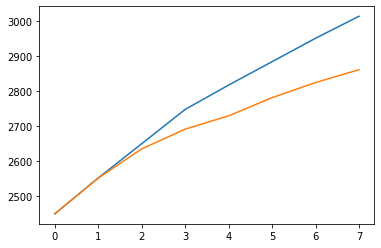

In [170]:
#Training Data
Train_value=[]
for i in range(0,len(ListOfResult)):
    if (i%300==0):
        #print(ListOfResult[i])
        Train_value.append(ListOfResult[i][0])
        #MSE=MSE+abs(ListOfRealityResult[int(i/300)]-ListOfResult[i][0])/(ListOfRealityResult[int(i/300)])
t=range(0,NumberOfValueToPredict+1)
plt.plot(t,Train_value)
plt.plot(t,ListOfRealityResult)
plt.show()